* Gurobipy commands for getting the results:

    * `printAttr('X')`:     Prints the values of all decision variables having non-zero values.
    * `objVal` or `ObjVal`: Gives the Objective values of the model.
    * `getVars()`:          Gives the list of values of all variables.
    * `model.getAttr(GRB.Attr.X, Name_of_varibles or list of variables)`:  Gets you the value of the variables requested.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
import scipy.stats as st
from gurobipy import *
import time
import numpy as np
import seaborn as sn

In [3]:
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use("fivethirtyeight")
plt.rcParams.update({'figure.autolayout': True})

##### Defining the Data

In [4]:
path = "C:/Users/garg1/Desktop/IAC Jupyter Files/demand_profile.csv";

#importing demand profile
demand_profile = pd.read_csv(path,header=None);
demand_profile = demand_profile.iloc[:50,:].copy()
nr_cust,nr_t = demand_profile.shape;

#demand_profile = demand_profile*2

#getting demand of the customers
demand = demand_profile.sum(axis=1).values;

#getting mean hourly demand of each customer
mean_hourly = np.rint(demand_profile.mean(axis=1).values)

#printing mean dats
print("\nMinimum Hourly Mean Demand= ",round(np.min(mean_hourly),ndigits=0),
        "\nMaximum Hourly Mean Demand= ",round(np.max(mean_hourly),ndigits=0),
        "\nMedian Hourly Mean Demand= ",round(np.median(mean_hourly),ndigits=0),
        "\nMode Hourly Mean Demand= ",st.mode(mean_hourly),
        "\nAverage Hourly Mean Demand= ",round(np.mean(mean_hourly),ndigits=0),
        "\nStandard Hourly Mean Demand= ",round(np.std(mean_hourly),ndigits=0))

# Loading Data Related to fuel
path = "C:/Users/garg1/Desktop/IAC Jupyter Files/fuel_properties.csv";
data2 = pd.read_csv(path);
data2['Eff- kWh/$/CO2'] = data2['kWh/Unit Fuel']*100/data2['Unit Price']/data2['CO2 lbs/Fuel Unit']
data2['Eff- kWh/$'] = data2['kWh/Unit Fuel']*100/data2['Unit Price']

#getting length of the data
nr_fuel = len(data2.index);

alpha_rate = list(data2["kWh/Unit Fuel"].values) #capturing kWh/fuel source
beta_rate = list(data2["CO2 lbs/Fuel Unit"].values) #capturing CO2 lbs/fuel source

fuel_supply=[]
capacities = [.50, .60, .20]
for i in range(nr_fuel):
    fuel_supply.append(round(demand.sum()*(capacities[i]/alpha_rate[i]),ndigits=0))


Minimum Hourly Mean Demand=  539.0 
Maximum Hourly Mean Demand=  109517.0 
Median Hourly Mean Demand=  8946.0 
Mode Hourly Mean Demand=  ModeResult(mode=array([539.]), count=array([1])) 
Average Hourly Mean Demand=  18606.0 
Standard Hourly Mean Demand=  25879.0


* __Defining all the cost Parameters__

In [5]:
#other fuel properties
cost_fuel = list(data2["Unit Price"].values) #capturing cost of unit fuel source

cost_ramp = 0.50; #ramping up or down cost

caligraphy_n = 24; #maximum number of price change allowed

#epsilon_rate = round(np.median(mean_hourly),ndigits=0); #maximum ramping allowed at no cost

epsilon_rate = round(np.median(mean_hourly),ndigits=0); #maximum ramping allowed at no cost

cost_gamma = [10,10,10,10,15,15,15,15,20,20,20,20,20,10,10,10,10,10,10,15,15,15,10,10]
#cost_gamma = [5,5,5,5,10,10,10,10,15,15,15,15,15,5,5,5,5,5,5,15,15,15,10,10]


cost_emission = 10;  #Penalty cost of CO2 emisisons

#inconvenience cost to the customer
cost_xi=pd.DataFrame(0,index=np.arange(nr_cust),columns=np.arange(nr_t));

#Maximum overconsumption allowed more than psi
omega_rate=pd.DataFrame(0,index=np.arange(nr_cust),columns=np.arange(nr_t));

for i in range(nr_cust):
    n = demand_profile.iloc[i,:].max()
    m = demand_profile.iloc[i,:].mean()
    for t in range(nr_t):
        r = demand_profile.iloc[i,t]
        cost_xi.iloc[i,t] = abs(round((1-(r/n))/5,ndigits=2))
        omega_rate.iloc[i,t] = abs(round(r*(1-r/n)*1,ndigits=0))

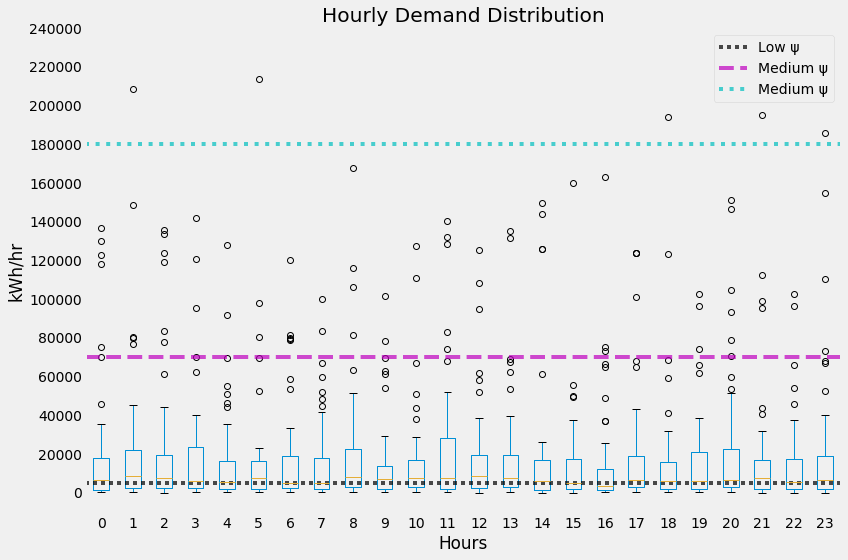

In [6]:
demand_profile.boxplot(column=list(demand_profile.columns), grid=False, figsize=(12,8));
plt.yticks(np.arange(0,250000,20000));
plt.axhline(y=5000, ls=(0,(1,1)), alpha=0.7, color='k', label='Low \u03C8')
plt.axhline(y=70000, ls='--', alpha=0.7, color='m', label='Medium \u03C8');
plt.axhline(y=180000, ls='dotted', alpha=0.7, color='c', label='Medium \u03C8');
plt.xlabel('Hours');
plt.ylabel('kWh/hr')
plt.legend();
plt.title('Hourly Demand Distribution');
#plt.savefig('demand_dist.jpg', quality=95)

In [7]:
gurobi_env=Env(empty=False);
gurobi_env.setParam('MIPGap',0.01);
gurobi_env.setParam('OutputFlag',1);
# gurobi_env.setParam('MIPFocus',3);
# gurobi_env.setParam('ImproveStartTime',300);
#gurobi_env.setParam('Cuts',3);
#gurobi_env.setParam('CliqueCuts',2);
#gurobi_env.setParam('FeasibilityTol',1e-3);
#gurobi_env.setParam('Presolve',0);
#gurobi_env.setParam('NodefileStart',0.5);
#gurobi_env.setParam('Threads',8);

Using license file C:\Users\garg1\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1


In [8]:
times=range(nr_t)
fuels=range(nr_fuel)
customers=range(nr_cust)

* __With Emission Model Function__

    * Create a user defined function to build & solve optimization model which considers the emission in the objection function.

In [9]:
def with_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission,data=data2):
    
    """Function to Write Model with Carbon Emissions"""
    
    MCE=Model(env=gurobi_env, name='MCE')

    #Defining Leaders' varfiable
    PIl = MCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="PIl")
    PIh = MCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="PIh")
    X = MCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="X")
    Y = MCE.addVars(fuels,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Y")
    P = MCE.addVars(times,vtype=GRB.BINARY,name="P")

    #defining followers variable
    Wl = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Wl")
    Wh = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Wh")
    Vplus = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Vplus")
    Vminus = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Vminus")
    U = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="U")

    #Defining KKT condition variables
    MUa = MCE.addVars(customers,times,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUa")
    MUb = MCE.addVars(customers,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUb")
    MUc = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUc")
    MUd = MCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUd")

    #McCormic
    rhoa = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoa")
    rhob = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhob")
    rhoc = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoc")
    rhod = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhod")
    rhoe = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoe")
    rhof = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhof")
    rhog = MCE.addVars(customers,times,vtype=GRB.BINARY,name="rhog")

    MCE.update()
    #Adding Constraints:

    #leader's
    MCE.addConstrs(
        (Wl.sum('*',t) + Wh.sum('*',t) - X[t] == 0 for t in range(nr_t)), name="9a")

    MCE.addConstrs(
        (quicksum(alpha_rate[s]*Y[s,t] for s in range(nr_fuel)) - X[t] == 0 for t in range(nr_t)), name="9b")

    #MCE.addConstrs((Y.sum(s,'*') <= fuel_supply[s] for s in range(nr_fuel)), name="9c")

    MCE.addConstrs(
        (PIl[t] - PIl[t+1] <= BIGM_price*P[t] for t in range(nr_t-1)), name="9d")
    MCE.addConstrs(
        (PIl[t] - PIl[t+1] >= -BIGM_price*P[t] for t in range(nr_t-1)), name="9d1")

    MCE.addConstrs(
        (PIh[t] - PIh[t+1] <= BIGM_price*P[t] for t in range(nr_t-1)), name="9e")
    MCE.addConstrs(
        (PIh[t] - PIh[t+1] >= -BIGM_price*P[t] for t in range(nr_t-1)), name="9e1")

    MCE.addConstr(
        (quicksum(P[t] for t in range(nr_t)) <= caligraphy_n), name="9f")

    MCE.addConstrs(
        (PIl[t] <= PIh[t] for t in range(nr_t)), name="9g")

    #Followers
    MCE.addConstrs(
        (Wl[k,t]+Wh[k,t]+Vminus[k,t]+U[k,t]-Vplus[k,t] == demand_profile.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="10a")

    MCE.addConstrs(
        (quicksum(Wl[k,t] + Wh[k,t] + U[k,t] for t in range(nr_t)) == demand[k] for k in range(nr_cust)), name="10b")

    MCE.addConstrs(
        (Wl[k,t] <= psi_rate for k in range(nr_cust) for t in range(nr_t)), name="10c")

    MCE.addConstrs(
        (Vplus[k,t] <= omega_rate.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="10d")
    
    MCE.update()

    #KKT Conditions
    
    #Stationary Constraints
    MCE.addConstrs(
        (MUa[k,t] + MUb[k] - MUc[k,t] <= PIl[t] for k in range(nr_cust) for t in range(nr_t)), name="11a")

    MCE.addConstrs(
        (MUa[k,t] + MUb[k] <= PIh[t] for k in range(nr_cust) for t in range(nr_t)), name="11b")

    MCE.addConstrs(
        (-MUa[k,t] - MUd[k,t] <= cost_xi.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11c")

    MCE.addConstrs(
        (MUa[k,t] <= 0 for k in range(nr_cust) for t in range(nr_t)), name="11d")

    MCE.addConstrs(
        (MUa[k,t] + MUb[k] <= cost_gamma[t] for k in range(nr_cust) for t in range(nr_t)), name="11e")
    
    #Complementary Slackness Condition Constraints
    MCE.addConstrs(
        (psi_rate - Wl[k,t] <= psi_rate*(1-rhoa[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11g")
    MCE.addConstrs(
        (MUc[k,t] <= BIGM_kkt1*rhoa[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11g1")

    MCE.addConstrs(
        (omega_rate.iloc[k,t]-Vplus[k,t] <= omega_rate.iloc[k,t]*(1-rhob[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11h")
    MCE.addConstrs(
        (MUd[k,t] <= BIGM_kkt1*rhob[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11h1")
    
    MCE.addConstrs(
        (PIl[t] - MUa[k,t] - MUb[k] + MUc[k,t] <= BIGM_kkt2*(1-rhoc[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11i")
    MCE.addConstrs(
        (Wl[k,t] <= psi_rate*rhoc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11i1")
    
    MCE.addConstrs(
        (PIh[t] - MUa[k,t] - MUb[k]<= BIGM_kkt2*(1-rhod[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11j")
    MCE.addConstrs(
        (Wh[k,t] <= (demand_profile.iloc[k,t]+omega_rate.iloc[k,t]-psi_rate)*rhod[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11j1")
    
    MCE.addConstrs(
        (cost_xi.iloc[k,t] + MUa[k,t] + MUd[k,t]  <= BIGM_kkt1*(1-rhoe[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11k")
    MCE.addConstrs(
        (Vplus[k,t] <= omega_rate.iloc[k,t]*rhoe[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11k1")
    
    MCE.addConstrs(
        (0 - MUa[k,t] <= BIGM_kkt1*(1-rhof[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11l")
    MCE.addConstrs(
        (Vminus[k,t] <= demand_profile.iloc[k,t]*rhof[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11l1")
    
    MCE.addConstrs(
        (cost_gamma[t] - MUa[k,t] - MUb[k] <= BIGM_kkt1*(1-rhog[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11m")
    MCE.addConstrs(
        (U[k,t] <= (demand_profile.iloc[k,t]+omega_rate.iloc[k,t])*rhog[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11m1")

    #setting up the objective

    MCE.setObjective(
        quicksum(demand_profile.iloc[k,t]*MUa[k,t] - psi_rate*MUc[k,t] - omega_rate.iloc[k,t]*MUd[k,t] - cost_gamma[t]*U[k,t]
                     -cost_xi.iloc[k,t]*Vplus[k,t] for k in range(nr_cust) for t in range(nr_t)) +
        quicksum(demand[k]*MUb[k] for k in range(nr_cust)) -
        quicksum(cost_fuel[s]*Y[s,t] for s in range(nr_fuel) for t in range(nr_t))-
        quicksum(cost_emission*beta_rate[s]*Y[s,t] for s in range(nr_fuel) for t in range(nr_t)), GRB.MAXIMIZE)

    MCE.update()
    
    MCE.reset(0)
    print('--------------------------\nStarted Solving MCE Model')
    MCE.optimize()
    
    MCE_obj = MCE.objVal
    print('Optimality Gap: {:.2f}'.format(MCE.MIPGap))
    
    #--------Capturing Details of Leaders----------------
    print('\n\tGetting Results\n--------------------------')
    
    #First create a list of all variables which are required to be output
    pil = [PIl[t] for t in range(nr_t)];
    pih = [PIh[t] for t in range(nr_t)];
    x = [X[t] for t in range(nr_t)];
    f1 = [Y[0,t] for t in range(nr_t)]; #Coal usage
    f2 = [Y[1,t] for t in range(nr_t)]; #Gas usage
    f3 = [Y[2,t] for t in range(nr_t)]; #Oil usage
    w_l = [];
    w_h = [];
    u = []
    vplus = []
    vminus = []
    for t in range(nr_t):
        w_l.append(sum(MCE.getAttr(GRB.Attr.X, [Wl[k,t] for k in range(nr_cust)])))
        w_h.append(sum(MCE.getAttr(GRB.Attr.X, [Wh[k,t] for k in range(nr_cust)])))
        u.append(sum(MCE.getAttr(GRB.Attr.X, [U[k,t] for k in range(nr_cust)])))
        vplus.append(sum(MCE.getAttr(GRB.Attr.X, [Vplus[k,t] for k in range(nr_cust)])))
        vminus.append(sum(MCE.getAttr(GRB.Attr.X, [Vminus[k,t] for k in range(nr_cust)])))
    
    df_leader = pd.DataFrame(index=range(nr_t));
    df_leader.index.name = 'Day-hours'
    
    df_leader['Low_Price'] = MCE.getAttr(GRB.Attr.X, pil);
    df_leader['High_Price'] = MCE.getAttr(GRB.Attr.X, pih);
    df_leader['Elec_Generated'] = MCE.getAttr(GRB.Attr.X, x);
    df_leader['Low_Price Demand'] = w_l
    df_leader['High_Price_Demand'] = w_h
    df_leader['Upward_Demand_Shifted'] = vplus
    df_leader['Downward_Demand_Shifted'] = vminus
    df_leader['Comp_Demand'] = u
    df_leader['Coal_Used'] = MCE.getAttr(GRB.Attr.X, f1);
    df_leader['Coal_Emissions (lbs)'] = df_leader['Coal_Used']*data.iloc[0,4];
    df_leader['Gas_Used'] = MCE.getAttr(GRB.Attr.X, f2);
    df_leader['Gas_Emissions (lbs)'] = df_leader['Gas_Used']*data.iloc[1,4];
    df_leader['Oil_Used'] = MCE.getAttr(GRB.Attr.X, f3);
    df_leader['Oil_Emissions (lbs)'] = df_leader['Oil_Used']*data.iloc[2,4];
    
    #--------Capturing Details of Followers----------------
    cust = ['Cust'+str(j) for j in range(nr_cust)]
    df_wh = pd.DataFrame(index=range(nr_t));
    df_wh.index.name = 'Day-hours'
    
    df_wl = pd.DataFrame(index=range(nr_t));
    df_wl.index.name = 'Day-hours'
    
    df_vplus = pd.DataFrame(index=range(nr_t));
    df_vplus.index.name = 'Day-hours'
    
    df_vminus = pd.DataFrame(index=range(nr_t));
    df_vminus.index.name = 'Day-hours'
    
    df_ukt = pd.DataFrame(index=range(nr_t));
    df_ukt.index.name = 'Day-hours'
    
    for k in range(nr_cust):
        df_wh[cust[k]] = MCE.getAttr(GRB.Attr.X, [Wh[k,t] for t in range(nr_t)])
        df_wl[cust[k]] = MCE.getAttr(GRB.Attr.X, [Wl[k,t] for t in range(nr_t)])
        df_vplus[cust[k]] = MCE.getAttr(GRB.Attr.X, [Vplus[k,t] for t in range(nr_t)])
        df_vminus[cust[k]] = MCE.getAttr(GRB.Attr.X, [Vminus[k,t] for t in range(nr_t)])
        df_ukt[cust[k]] = MCE.getAttr(GRB.Attr.X, [U[k,t] for t in range(nr_t)])

    
    return MCE_obj, df_leader.round(0), df_wh.round(0), df_wl.round(0), df_vplus.round(0), df_vminus.round(0), df_ukt.round(0)

* __Without Emission Model Function__

    * Create a user defined function to build & solve optimization model which does not consider the emission in the objection function.

In [10]:
def without_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission,data=data2):
    
    """Without Emission Model"""
    
    MWCE=Model(env=gurobi_env, name='MWCE')

    #Defining Leaders' varfiable
    PIl = MWCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="PIl")
    PIh = MWCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="PIh")
    X = MWCE.addVars(times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="X")
    Y = MWCE.addVars(fuels,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Y")
    P = MWCE.addVars(times,vtype=GRB.BINARY,name="P")

    #defining followers variable
    Wl = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Wl")
    Wh = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Wh")
    Vplus = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Vplus")
    Vminus = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="Vminus")
    U = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="U")

    #Defining KKT condition variables
    MUa = MWCE.addVars(customers,times,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUa")
    MUb = MWCE.addVars(customers,lb=-GRB.INFINITY,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUb")
    MUc = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUc")
    MUd = MWCE.addVars(customers,times,lb=0.0,ub=GRB.INFINITY,vtype=GRB.CONTINUOUS,name="MUd")

    #McCormic
    rhoa = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoa")
    rhob = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhob")
    rhoc = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoc")
    rhod = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhod")
    rhoe = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhoe")
    rhof = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhof")
    rhog = MWCE.addVars(customers,times,vtype=GRB.BINARY,name="rhog")

    MWCE.update()
    #Adding Constraints:

    #leader's
    MWCE.addConstrs(
        (Wl.sum('*',t) + Wh.sum('*',t) - X[t] == 0 for t in range(nr_t)), name="9a")

    MWCE.addConstrs(
        (quicksum(alpha_rate[s]*Y[s,t] for s in range(nr_fuel)) - X[t] == 0 for t in range(nr_t)), name="9b")

    #MWCE.addConstrs((Y.sum(s,'*') <= fuel_supply[s] for s in range(nr_fuel)), name="9c")

    MWCE.addConstrs(
        (PIl[t] - PIl[t+1] <= BIGM_price*P[t] for t in range(nr_t-1)), name="9d")
    MWCE.addConstrs(
        (PIl[t] - PIl[t+1] >= -BIGM_price*P[t] for t in range(nr_t-1)), name="9d1")

    MWCE.addConstrs(
        (PIh[t] - PIh[t+1] <= BIGM_price*P[t] for t in range(nr_t-1)), name="9e")
    MWCE.addConstrs(
        (PIh[t] - PIh[t+1] >= -BIGM_price*P[t] for t in range(nr_t-1)), name="9e1")

    MWCE.addConstr(
        (quicksum(P[t] for t in range(nr_t)) <= caligraphy_n), name="9f")

    MWCE.addConstrs(
        (PIl[t] <= PIh[t] for t in range(nr_t)), name="9g")

    #Followers
    MWCE.addConstrs(
        (Wl[k,t]+Wh[k,t]+Vminus[k,t]+U[k,t]-Vplus[k,t] == demand_profile.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="10a")

    MWCE.addConstrs(
        (quicksum(Wl[k,t] + Wh[k,t] + U[k,t] for t in range(nr_t)) == demand[k] for k in range(nr_cust)), name="10b")

    MWCE.addConstrs(
        (Wl[k,t] <= psi_rate for k in range(nr_cust) for t in range(nr_t)), name="10c")

    MWCE.addConstrs(
        (Vplus[k,t] <= omega_rate.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="10d")
    
    MWCE.update()

    #KKT Conditions
    
    #Stationary Constraints
    MWCE.addConstrs(
        (MUa[k,t] + MUb[k] - MUc[k,t] <= PIl[t] for k in range(nr_cust) for t in range(nr_t)), name="11a")

    MWCE.addConstrs(
        (MUa[k,t] + MUb[k] <= PIh[t] for k in range(nr_cust) for t in range(nr_t)), name="11b")

    MWCE.addConstrs(
        (-MUa[k,t] - MUd[k,t] <= cost_xi.iloc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11c")

    MWCE.addConstrs(
        (MUa[k,t] <= 0 for k in range(nr_cust) for t in range(nr_t)), name="11d")

    MWCE.addConstrs(
        (MUa[k,t] + MUb[k] <= cost_gamma[t] for k in range(nr_cust) for t in range(nr_t)), name="11e")
    
    #Complementary Slackness Condition Constraints
    MWCE.addConstrs(
        (psi_rate - Wl[k,t] <= psi_rate*(1-rhoa[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11g")
    MWCE.addConstrs(
        (MUc[k,t] <= BIGM_kkt1*rhoa[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11g1")

    MWCE.addConstrs(
        (omega_rate.iloc[k,t]-Vplus[k,t] <= omega_rate.iloc[k,t]*(1-rhob[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11h")
    MWCE.addConstrs(
        (MUd[k,t] <= BIGM_kkt1*rhob[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11h1")
    
    MWCE.addConstrs(
        (PIl[t] - MUa[k,t] - MUb[k] + MUc[k,t] <= BIGM_kkt2*(1-rhoc[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11i")
    MWCE.addConstrs(
        (Wl[k,t] <= psi_rate*rhoc[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11i1")
    
    MWCE.addConstrs(
        (PIh[t] - MUa[k,t] - MUb[k]<= BIGM_kkt2*(1-rhod[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11j")
    MWCE.addConstrs(
        (Wh[k,t] <= (demand_profile.iloc[k,t]+omega_rate.iloc[k,t]-psi_rate)*rhod[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11j1")
    
    MWCE.addConstrs(
        (cost_xi.iloc[k,t] + MUa[k,t] + MUd[k,t]  <= BIGM_kkt1*(1-rhoe[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11k")
    MWCE.addConstrs(
        (Vplus[k,t] <= omega_rate.iloc[k,t]*rhoe[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11k1")
    
    MWCE.addConstrs(
        (0 - MUa[k,t] <= BIGM_kkt1*(1-rhof[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11l")
    MWCE.addConstrs(
        (Vminus[k,t] <= demand_profile.iloc[k,t]*rhof[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11l1")
    
    MWCE.addConstrs(
        (cost_gamma[t] - MUa[k,t] - MUb[k] <= BIGM_kkt1*(1-rhog[k,t]) for k in range(nr_cust) for t in range(nr_t)), name="11m")
    MWCE.addConstrs(
        (U[k,t] <= (demand_profile.iloc[k,t]+omega_rate.iloc[k,t])*rhog[k,t] for k in range(nr_cust) for t in range(nr_t)), name="11m1")

    #setting up the objective

    MWCE.setObjective(
        quicksum(demand_profile.iloc[k,t]*MUa[k,t] - psi_rate*MUc[k,t] - omega_rate.iloc[k,t]*MUd[k,t] - cost_gamma[t]*U[k,t]
                     -cost_xi.iloc[k,t]*Vplus[k,t] for k in range(nr_cust) for t in range(nr_t)) +
        quicksum(demand[k]*MUb[k] for k in range(nr_cust)) -
        quicksum(cost_fuel[s]*Y[s,t] for s in range(nr_fuel) for t in range(nr_t)), GRB.MAXIMIZE)

    MWCE.update()
    
    MWCE.reset(0)
    print(f'--------------------------\nStarted Solving MWCE Model {psi_rate}')
    MWCE.optimize()
    
    MWCE_obj = MWCE.objVal
    
    
    #--------Capturing Details of Leaders----------------
    
    print('\n\tGetting Results\n--------------------------')
    
    #First create a list of all variables which are required to be output
    pil = [PIl[t] for t in range(nr_t)];
    pih = [PIh[t] for t in range(nr_t)];
    x = [X[t] for t in range(nr_t)];
    f1 = [Y[0,t] for t in range(nr_t)]; #Coal usage
    f2 = [Y[1,t] for t in range(nr_t)]; #Gas usage
    f3 = [Y[2,t] for t in range(nr_t)]; #Oil usage
    w_l = [];
    w_h = [];
    u = []
    vplus = []
    vminus = []
    for t in range(nr_t):
        w_l.append(sum(MWCE.getAttr(GRB.Attr.X, [Wl[k,t] for k in range(nr_cust)])))
        w_h.append(sum(MWCE.getAttr(GRB.Attr.X, [Wh[k,t] for k in range(nr_cust)])))
        u.append(sum(MWCE.getAttr(GRB.Attr.X, [U[k,t] for k in range(nr_cust)])))
        vplus.append(sum(MWCE.getAttr(GRB.Attr.X, [Vplus[k,t] for k in range(nr_cust)])))
        vminus.append(sum(MWCE.getAttr(GRB.Attr.X, [Vminus[k,t] for k in range(nr_cust)])))
    
    df_leader = pd.DataFrame(index=range(nr_t));
    df_leader.index.name = 'Day-hours'
    
    df_leader['Low_Price'] = MWCE.getAttr(GRB.Attr.X, pil);
    df_leader['High_Price'] = MWCE.getAttr(GRB.Attr.X, pih);
    df_leader['Elec_Generated'] = MWCE.getAttr(GRB.Attr.X, x);
    df_leader['Low_Price Demand'] = w_l
    df_leader['High_Price_Demand'] = w_h
    df_leader['Upward_Demand_Shifted'] = vplus
    df_leader['Downward_Demand_Shifted'] = vminus
    df_leader['Comp_Demand'] = u
    df_leader['Coal_Used'] = MWCE.getAttr(GRB.Attr.X, f1);
    df_leader['Coal_Emissions (lbs)'] = df_leader['Coal_Used']*data.iloc[0,4];
    df_leader['Gas_Used'] = MWCE.getAttr(GRB.Attr.X, f2);
    df_leader['Gas_Emissions (lbs)'] = df_leader['Gas_Used']*data.iloc[1,4];
    df_leader['Oil_Used'] = MWCE.getAttr(GRB.Attr.X, f3);
    df_leader['Oil_Emissions (lbs)'] = df_leader['Oil_Used']*data.iloc[2,4];
    
    #--------Capturing Details of Followers----------------
    cust = ['Cust'+str(j) for j in range(nr_cust)]
    df_wh = pd.DataFrame(index=range(nr_t));
    df_wh.index.name = 'Day-hours'
    
    df_wl = pd.DataFrame(index=range(nr_t));
    df_wl.index.name = 'Day-hours'
    
    df_vplus = pd.DataFrame(index=range(nr_t));
    df_vplus.index.name = 'Day-hours'
    
    df_vminus = pd.DataFrame(index=range(nr_t));
    df_vminus.index.name = 'Day-hours'
    
    df_ukt = pd.DataFrame(index=range(nr_t));
    df_ukt.index.name = 'Day-hours'
    
    for k in range(nr_cust):
        df_wh[cust[k]] = MWCE.getAttr(GRB.Attr.X, [Wh[k,t] for t in range(nr_t)])
        df_wl[cust[k]] = MWCE.getAttr(GRB.Attr.X, [Wl[k,t] for t in range(nr_t)])
        df_vplus[cust[k]] = MWCE.getAttr(GRB.Attr.X, [Vplus[k,t] for t in range(nr_t)])
        df_vminus[cust[k]] = MWCE.getAttr(GRB.Attr.X, [Vminus[k,t] for t in range(nr_t)])
        df_ukt[cust[k]] = MWCE.getAttr(GRB.Attr.X, [U[k,t] for t in range(nr_t)])
    
    return MWCE_obj, df_leader.round(0), df_wh.round(0), df_wl.round(0), df_vplus.round(0), df_vminus.round(0), df_ukt.round(0)

# Computational Experiments


* Define the values of BIG-M and $\Psi$ for which both models will be solved

In [12]:
BIGM_price=100; #Big M for capturing the price changes
BIGM_kkt1=20;  #Big M for McCormic Constraints-MUd
BIGM_kkt2=50;  #Big M for McCormic Constraints for Mua, MUb, MUc
BIGM_kkt3=200;  #Big M for McCormic Constraints-MUa
psi_labels = ['Low \u03C8', 'Medium \u03C8', 'High \u03C8']
psi_values = [5000, 70000,180000] #low, Medium, High Psi Values

* __Store the Results__

In [13]:
Profits_Actual_MCE = {}
Profits_Wghited_MCE = {}
Emission_Cost_MCE = {}
Retailer_Profits_MCE = {}

Profits_Actual_MWCE = {}
Profits_Wghited_MWCE = {}
Emission_Cost_MWCE = {}
Retailer_Profits_MWCE = {}

### Solve for `Low` $\Psi$

In [14]:
psi_rate = psi_values[0]

print(f'Psi Value: {psi_rate}')
MCE_obj,low_MCE_leader,low_MCE_wh,low_MCE_wl,low_MCE_vplus,low_MCE_vminus,low_MCE_ukt = with_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MCE['Low'] = MCE_obj

MWCE_obj,low_MWCE_leader,low_MWCE_wh,low_MWCE_wl,low_MWCE_vplus,low_MWCE_vminus,low_MWCE_ukt = without_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MWCE['Low'] = MWCE_obj

Psi Value: 5000
Discarded solution information
--------------------------
Started Solving MCE Model
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 26615 rows, 18218 columns and 71168 nonzeros
Model fingerprint: 0x70f749fa
Variable types: 9794 continuous, 8424 integer (8424 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e-02, 3e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+06]
Presolve removed 6274 rows and 2576 columns
Presolve time: 0.52s
Presolved: 20341 rows, 15642 columns, 58457 nonzeros
Variable types: 8256 continuous, 7386 integer (7386 binary)

Root relaxation: objective 1.537215e+08, 7662 iterations, 0.28 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.5372e+08    0 1107          - 1.5372e+08      -     -    5s
     0     0 1.5353e+08    0  631          - 1.5353

  2269  2202 2.4685e+08  123  410          - 2.4804e+08      -  61.5  193s
  2273  2205 2.4771e+08  101   67          - 2.4804e+08      -  61.3  196s
  2275  2206 2.4699e+08  182   65          - 2.4804e+08      -  61.3  200s
  2276  2207 2.4802e+08   14   66          - 2.4804e+08      -  61.3  207s
H 2277  2096                    2.480417e+08 2.4804e+08  0.00%  61.2  214s

Cutting planes:
  Learned: 8
  Gomory: 169
  Cover: 7
  Implied bound: 14
  Projected implied bound: 9
  Clique: 7
  MIR: 652
  Flow cover: 1553
  Network: 1
  RLT: 4
  Relax-and-lift: 480

Explored 2277 nodes (173684 simplex iterations) in 214.71 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2.48042e+08 

Optimal solution found (tolerance 1.00e-02)
Best objective 2.480416660706e+08, best bound 2.480430623515e+08, gap 0.0006%

	Getting Results
--------------------------


In [15]:
low_MCE_leader.to_csv('low_MCE_leader.csv')
low_MCE_wh.to_csv('low_MCE_wh.csv')
low_MCE_wl.to_csv('low_MCE_wl.csv')
low_MCE_vplus.to_csv('low_MCE_vplus.csv')
low_MCE_vminus.to_csv('low_MCE_vminus.csv')
low_MCE_ukt.to_csv('low_MCE_ukt.csv')

low_MWCE_leader.to_csv('low_MWCE_leader.csv')
low_MWCE_wh.to_csv('low_MWCE_wh.csv')
low_MWCE_wl.to_csv('low_MWCE_wl.csv')
low_MWCE_vplus.to_csv('low_MWCE_vplus.csv')
low_MWCE_vminus.to_csv('low_MWCE_vminus.csv')
low_MWCE_ukt.to_csv('low_MWCE_ukt.csv')

### Solve for `Medium` $\Psi$

In [18]:
psi_rate = psi_values[1]

print(f'Psi Value: {psi_rate}')
MCE_obj,med_MCE_leader,med_MCE_wh,med_MCE_wl,med_MCE_vplus,med_MCE_vminus,med_MCE_ukt = with_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MCE['Medium'] = MCE_obj

MWCE_obj,med_MWCE_leader,med_MWCE_wh,med_MWCE_wl,med_MWCE_vplus,med_MWCE_vminus,med_MWCE_ukt = without_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MWCE['Medium'] = MWCE_obj

Psi Value: 70000
Discarded solution information
--------------------------
Started Solving MCE Model
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 26615 rows, 18218 columns and 71168 nonzeros
Model fingerprint: 0xb452fb7e
Variable types: 9794 continuous, 8424 integer (8424 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e-02, 3e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+06]
Presolve removed 9400 rows and 5721 columns
Presolve time: 0.21s
Presolved: 17215 rows, 12497 columns, 49586 nonzeros
Variable types: 6381 continuous, 6116 integer (6116 binary)

Root relaxation: objective 1.537224e+08, 6898 iterations, 0.10 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.5372e+08    0  965          - 1.5372e+08      -     -    2s
     0     0 1.5353e+08    0  530          - 1.535


	Getting Results
--------------------------


In [19]:
med_MCE_leader.to_csv('med_MCE_leader.csv')
med_MCE_wh.to_csv('med_MCE_wh.csv')
med_MCE_wl.to_csv('med_MCE_wl.csv')
med_MCE_vplus.to_csv('med_MCE_vplus.csv')
med_MCE_vminus.to_csv('med_MCE_vminus.csv')
med_MCE_ukt.to_csv('med_MCE_ukt.csv')

med_MWCE_leader.to_csv('med_MWCE_leader.csv')
med_MWCE_wh.to_csv('med_MWCE_wh.csv')
med_MWCE_wl.to_csv('med_MWCE_wl.csv')
med_MWCE_vplus.to_csv('med_MWCE_vplus.csv')
med_MWCE_vminus.to_csv('med_MWCE_vminus.csv')
med_MWCE_ukt.to_csv('med_MWCE_ukt.csv')

### Solve for `High` $\Psi$

In [16]:
psi_rate = psi_values[2]

print(f'Psi Value: {psi_rate}')
MCE_obj,high_MCE_leader,high_MCE_wh,high_MCE_wl,high_MCE_vplus,high_MCE_vminus,high_MCE_ukt = with_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MCE['High'] = MCE_obj

MWCE_obj,high_MWCE_leader,high_MWCE_wh,high_MWCE_wl,high_MWCE_vplus,high_MWCE_vminus,high_MWCE_ukt = without_emission(nr_t,nr_fuel,nr_cust,alpha_rate,fuel_supply,epsilon_rate,BIGM_price,caligraphy_n,beta_rate,
                  demand_profile,demand,psi_rate,omega_rate,cost_xi,cost_gamma,BIGM_kkt1,BIGM_kkt2,BIGM_kkt3,
                  cost_fuel,cost_ramp,cost_emission)

Profits_Actual_MWCE['High'] = MWCE_obj

Psi Value: 180000
Discarded solution information
--------------------------
Started Solving MCE Model
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 26615 rows, 18218 columns and 71168 nonzeros
Model fingerprint: 0x1f391335
Variable types: 9794 continuous, 8424 integer (8424 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e-02, 3e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-02, 3e+06]
Presolve removed 10674 rows and 6303 columns
Presolve time: 0.38s
Presolved: 15941 rows, 11915 columns, 45900 nonzeros
Variable types: 6029 continuous, 5886 integer (5886 binary)
Found heuristic solution: objective 1.128395e+08

Root relaxation: objective 1.537216e+08, 6672 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.5372e+08    0  917 1.1284e+08 1.5372e+08  36.2%     -    3s

     0     2 2.4806e+08    0  212 2.0746e+08 2.4806e+08  19.6%     -   23s
    23    29 2.4806e+08    5  215 2.0746e+08 2.4806e+08  19.6%   235   25s
    28    33 2.4687e+08    6  480 2.0746e+08 2.4806e+08  19.6%   445   61s
   174   282 2.4805e+08   27  126 2.0746e+08 2.4806e+08  19.6%   181   65s
   725   865 2.4805e+08   20  125 2.0746e+08 2.4806e+08  19.6%  68.3   70s
  1253  1561 2.4686e+08   54  438 2.0746e+08 2.4806e+08  19.6%  63.5   76s
  1620  1697 2.4685e+08  169  307 2.0746e+08 2.4806e+08  19.6%  55.3  172s
  1756  1727 2.4680e+08  194  324 2.0746e+08 2.4806e+08  19.6%  53.9  208s
H 1759  1727                    2.075687e+08 2.4806e+08  19.5%  53.8  208s
  1822  2124 2.4684e+08  194  281 2.0757e+08 2.4806e+08  19.5%  55.3  212s
  2284  2125 2.1252e+08  246  224 2.0757e+08 2.4806e+08  19.5%  54.5  231s
  2286  2126 2.4700e+08  117  883 2.0757e+08 2.4806e+08  19.5%  54.5  249s
  2287  2127 2.4701e+08  131  720 2.0757e+08 2.4806e+08  19.5%  54.5  250s
  2298  2134 2.1286e+08  

In [17]:
high_MCE_leader.to_csv('high_MCE_leader.csv')
high_MCE_wh.to_csv('high_MCE_wh.csv')
high_MCE_wl.to_csv('high_MCE_wl.csv')
high_MCE_vplus.to_csv('high_MCE_vplus.csv')
high_MCE_vminus.to_csv('high_MCE_vminus.csv')
high_MCE_ukt.to_csv('high_MCE_ukt.csv')

high_MWCE_leader.to_csv('high_MWCE_leader.csv')
high_MWCE_wh.to_csv('high_MWCE_wh.csv')
high_MWCE_wl.to_csv('high_MWCE_wl.csv')
high_MWCE_vplus.to_csv('high_MWCE_vplus.csv')
high_MWCE_vminus.to_csv('high_MWCE_vminus.csv')
high_MWCE_ukt.to_csv('high_MWCE_ukt.csv')

In [20]:
Profits_Actual_MWCE, Profits_Actual_MCE

({'Low': 248041666.07059878,
  'High': 248041666.07059884,
  'Medium': 248041666.0705971},
 {'Low': 153422029.68793482,
  'High': 153422029.68793482,
  'Medium': 153422029.68793476})

In [23]:
Emission_Cost_MWCE, Emission_Cost_MCE

({'Low': 164567350.0, 'Medium': 164567350.0, 'High': 164567360.0},
 {'Low': 89496170.0, 'Medium': 89496180.0, 'High': 89496160.0})